In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.modelUtils.gnn as gnn

In [2]:
tree = Tree(fc.passthrough.NMSSM_MX_600_MY_400)

In [3]:
graphs = gnn.Dataset('.',tree)

In [4]:
ngraphs = len(graphs)
ngraphs

45168

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

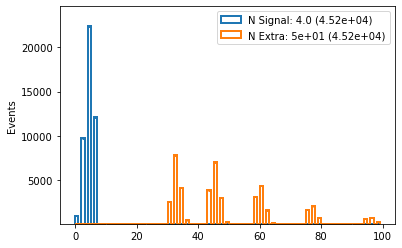

In [5]:
labels = ak.Array([g.edge_y.tolist() for g in graphs])

nsig = ak.sum(labels==1,axis=-1)
nbkg = ak.sum(labels==0,axis=-1)

msig = ak.mean(nsig)
mbkg = ak.mean(nbkg)

hist_multi([nsig,nbkg],labels=[f"N Signal: {msig:.2}",f"N Extra: {mbkg:.2}"],bins=range(0,100))

In [6]:
class_weights = msig/np.array([mbkg,msig])
class_weights

array([0.07998312, 1.        ])

In [7]:
graphs[0]

Data(x=[7, 5], edge_index=[2, 49], y=[7], pos_edge_index=[2, 6], edge_x=[49, 1], edge_y=[49])

In [8]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

def train_test_split(dataset,test_split):
    size = len(dataset)
    train_size = int(size*(1-test_split))
    test_size = size - train_size
    return random_split(dataset,[train_size,test_size])

training,testing = train_test_split(graphs, 0.25)
training,validation = train_test_split(training,0.2)

trainloader = DataLoader(training,batch_size=50,shuffle=True,num_workers=4)
testloader = DataLoader(testing,batch_size=50,num_workers=4)
validloader = DataLoader(validation,batch_size=50,num_workers=4)

In [9]:
from torch_geometric.typing import PairTensor, Adj
from typing import Union, Callable
import torch_geometric
from torch import Tensor
import awkward as ak
import torch
from torch_geometric.nn.inits import reset

class EdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, nn1: Callable, nn2: Callable, aggr: str = 'max', **kwargs):
        super(EdgeConv,self).__init__(aggr,**kwargs)
        self.nn1, self.nn2 = nn1, nn2
        self.E: Tensor = Tensor()
        self.reset_parameters()
    def reset_parameters(self):
        reset(self.nn1)
        reset(self.nn2)

    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj, edge_x: Tensor) -> Tensor:
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        # propagate_type: (x: PairTensor)
        x_tilde = self.propagate(edge_index, x=x, edge_x=edge_x)     
        m2 = torch.cat([x_tilde[edge_index[1]],x_tilde[edge_index[0]],self.E],dim=1)
        return self.nn2(m2)

    def message(self, x_i: Tensor, x_j: Tensor, edge_x: Tensor) -> Tensor:
        m1 = torch.cat([x_i, x_j - x_i, edge_x], dim=-1)
        self.E = self.nn1(m1)
        return self.E

In [10]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch_geometric.nn import Linear


class GCN(pl.LightningModule):
    def __init__(self, node_features, edge_features, nclasses):
        super().__init__()

        nn1 = torch.nn.Sequential(
            Linear(2*node_features+edge_features,16),
            torch.nn.ReLU(), 
            Linear(16,32)
        )

        nn2 = torch.nn.Sequential(
            Linear(3*32,128),
            torch.nn.ReLU(), 
            Linear(128,nclasses)
        )

        self.conv1 = EdgeConv(nn1,nn2,aggr='max')
        self.class_weights = Tensor(class_weights)

    def forward(self, data):
        x, edge_index, edge_x = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x,edge_index,edge_x)

        return F.log_softmax(x, dim=1)
    def shared_step(self, batch, batch_idx, tag=None):
        o = self(batch)
        loss = F.nll_loss(o, batch.edge_y.long(),self.class_weights)
        acc = accuracy(o.argmax(dim=1), batch.edge_y.long())

        metrics = dict(loss=loss, acc=acc)
        if tag is not None:
            metrics = {f'{tag}_{key}': value for key, value in metrics.items()}

        self.log_dict(metrics)
        return metrics

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, tag='val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, tag='test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [11]:
model = GCN(5,1,2)

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(max_epochs=5,callbacks=[EarlyStopping(monitor='val_loss')])
trainer.fit(model,trainloader,validloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type     | Params
-----------------------------------
0 | conv1 | EdgeConv | 13.4 K
-----------------------------------
13.4 K    Trainable params
0         Non-trainable params
13.4 K    Total params
0.054     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/uscms/home/ekoenig/nobackup/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
trainer.test(model,validloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7724160552024841, 'test_loss': 0.40235599875450134}
--------------------------------------------------------------------------------


[{'test_loss': 0.40235599875450134, 'test_acc': 0.7724160552024841}]

In [14]:
trainer.test(model,testloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7717999219894409, 'test_loss': 0.39934977889060974}
--------------------------------------------------------------------------------


[{'test_loss': 0.39934977889060974, 'test_acc': 0.7717999219894409}]

In [15]:
import sklearn.metrics as metrics

y_true,y_pred = [],[]
for test in testloader: 
    y_true = np.concatenate([y_true,test.edge_y.long()])
    y_pred = np.concatenate([y_pred,model(test)[:,1].detach()])

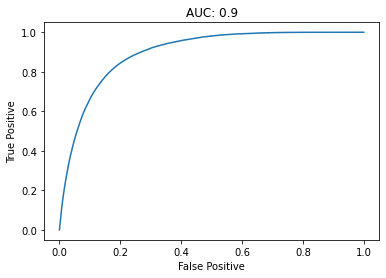

In [16]:
fpr,tpr,thresholds = metrics.roc_curve(y_true,y_pred)
auc = metrics.auc(fpr,tpr)

graph_simple(fpr,tpr,xlabel="False Positive",ylabel="True Positive",title=f"AUC: {auc:.2}",marker=None);